# Checking label noise using cleanlab in MLRNet 

A quick spike to look at label-noise handling using [cleanlab](github.com/cleanlab/cleanlab/) on [MLRSNet](https://paperswithcode.com/dataset/mlrsnet). 

The model was trained using [label-noise](https://github.com/suneeta-mall/label-noise) application which is a spike build using ResNet as multi-label image classifier predicting 6 classes that can co-exists at the same time. These classes are `['airplane', 'airport', 'buildings', 'cars', 'runway', 'trees'] ` and derived off [MLRSNet](https://paperswithcode.com/dataset/mlrsnet) subset - i.e. only using `airplane` and `airport`. Reason to trim was none other than a quick spike!

This notebook checks how well [cleanlab](github.com/cleanlab/cleanlab/) performs in detecting label-noise, identifies out of distribution samples, weird samples and also errors!

The source code and supporting content for this spike is can be found in this [github repo - label-noise](https://github.com/suneeta-mall/label-noise) and more background post can be found in [this blog](https://suneeta-mall.github.io/2022/05/16/confident-learning-clean-data.html)

In [1]:
from pathlib import Path

import cleanlab
import matplotlib.pyplot as plt
import numpy as np
import torch
from cleanlab import filter
from cleanlab.filter import find_label_issues
from pytorch_lightning import Trainer

from label_noise.dataset import MLRNetModule
from label_noise.dataset.transforms import UnNormalise
from label_noise.model import ResNeXT

/Users/suneeta.mall/Library/Caches/pypoetry/virtualenvs/label-noise-dKL4Obl--py3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_directory=Path("MLRNet/7j9bv9vwsx-3/")
model_fn=Path("logs/example_model.ckpt")
output_dir=Path("logs")
batch_size=256
num_devices=[]
num_workers=12

## Prepare 

Here, we use a pre-trained model and use model-in-the-loop technique, as mentioned [this blog](https://suneeta-mall.github.io/2022/05/16/confident-learning-clean-data.html), to disagreement between the model and the ground truth. Following that, is some posthoc to prep for cleanlab magic!

![](http://0.0.0.0:4000/images/data-centric-ai/cleanlab/cl.jpg)
![](https://suneeta-mall.github.io/images/data-centric-ai/cleanlab/cl.jpg)

In [3]:
data_module = MLRNetModule(
    data_directory,
    batch_size=batch_size,
    num_workers=num_workers,
)
data_module.setup("test")

model = ResNeXT.load_from_checkpoint(checkpoint_path=model_fn)
model.eval()

trainer = Trainer(
    gpus=num_devices,
    auto_select_gpus=True,
    max_epochs=256,    
)

results = trainer.predict(model, data_module)
predictions = torch.cat(tuple(results[i][0] for i in range(len(results))))
images = torch.cat(tuple(results[i][1][0] for i in range(len(results))))
truth = torch.cat(tuple(results[i][1][1] for i in range(len(results))))

reverse_ohe_truth = [torch.where(x_i == 1)[0].cpu().numpy().tolist() for x_i in torch.unbind(truth, dim=0)]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:30<00:00, 15.37s/it]


## Using cleanlab for multi-label setting

To be honest, I am not entirly clear how cleanlab handles multi-label case with pairwise joint distribution that looks at off-diagonal samples in metrics to detect noise. Its not touch on in detail in neither the [founding paper](https://arxiv.org/abs/1911.00068) nor [the analysis one](https://arxiv.org/abs/2103.14749), as also mentioned in [this blog](https://suneeta-mall.github.io/2022/05/16/confident-learning-clean-data.html). The library seem to work however except some [APIs that perhaps do not support multi-label](https://github.com/cleanlab/cleanlab/issues/263).

It's great to see the support is there nonetheless. I have not invested in great deal looking code just yet but thats next step from here. 

Now, lets look at what our pudding says!

## 1. Filter

One of the approach of cleanlab is to filter the data set by removing noisy samples. To identify noisy, cleanlab uses [confident learning](https://suneeta-mall.github.io/2022/05/16/confident-learning-clean-data.html).

/Users/suneeta.mall/Library/Caches/pypoetry/virtualenvs/label-noise-dKL4Obl--py3.9/lib/python3.9/site-packages/cleanlab/filter.py:453: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  labels = np.asarray(labels)


152 395 0.3848101265822785


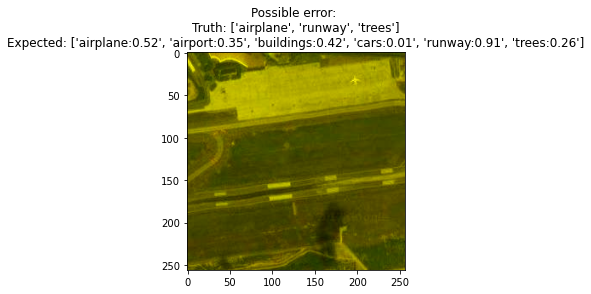

In [39]:
ordered_label_errors = find_label_issues(
    reverse_ohe_truth,
    predictions.cpu().numpy(),
    return_indices_ranked_by="normalized_margin",  # Orders label errors
    multi_label=True,
)

sample_idxs=np.random.choice(ordered_label_errors.shape[0], 5, replace=False,)
for idx in ordered_label_errors[sample_idxs]:
    img = UnNormalise()(images[idx])
    plt.imshow(np.transpose(img.cpu().numpy(), [1, 2, 0]))
    expected_str = [f"{b}:{np.round(float(a), 2)}" for a, b in zip(predictions[idx], data_module.categories())]
    title = f"Possible error: \nTruth: {[data_module.categories()[a] for a in reverse_ohe_truth[idx]]}\nExpected: {expected_str}"
    plt.title(title)
    plt.draw()
    
print(len(ordered_label_errors), len(reverse_ohe_truth), len(ordered_label_errors)/len(reverse_ohe_truth))

Ok, this was not very helpful. Lets try again with `self_confidence` as indices order.

/Users/suneeta.mall/Library/Caches/pypoetry/virtualenvs/label-noise-dKL4Obl--py3.9/lib/python3.9/site-packages/cleanlab/filter.py:453: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  labels = np.asarray(labels)


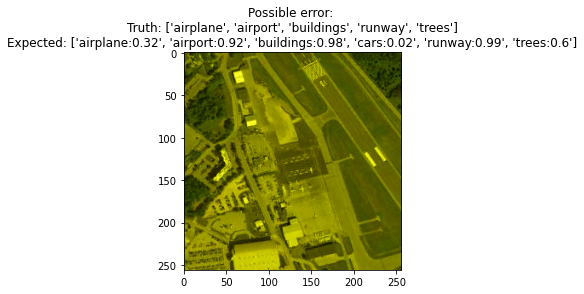

In [36]:
ordered_label_errors = find_label_issues(
    reverse_ohe_truth,
    predictions.cpu().numpy(),
    return_indices_ranked_by="self_confidence",  # Orders label errors
    multi_label=True,
)

sample_idxs=np.random.choice(ordered_label_errors.shape[0], 5, replace=False,)
for idx in ordered_label_errors[sample_idxs]:
    img = UnNormalise()(images[idx])
    plt.imshow(np.transpose(img.cpu().numpy(), [1, 2, 0]))
    expected_str = [f"{b}:{np.round(float(a), 2)}" for a, b in zip(predictions[idx], data_module.categories())]
    title = f"Possible error: \nTruth: {[data_module.categories()[a] for a in reverse_ohe_truth[idx]]}\nExpected: {expected_str}"
    plt.title(title)
    plt.draw()


This is not very helpful either! Sadly by themselves!

## 2. Rank

Rank is the technique to score the samples by order of quality scores! API spec is [here](https://docs.cleanlab.ai/v2.0.0/cleanlab/rank.html) however
I have chosen an API that focuses on finding out-of-distribution (OOD), weird, bad and like other interesting cases! This API also supports multi-label
This API relates to self-confidence `get_self_confidence_for_each_label`.

{'whiskers': [<matplotlib.lines.Line2D at 0x7fb8d92bbe20>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb8d92d1400>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb8d92bbb50>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb8d92d19a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fb8d92d1c70>],
 'means': []}

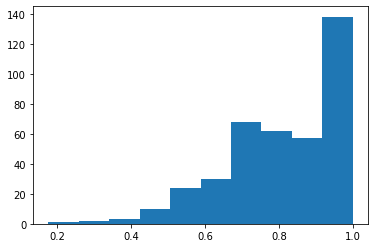

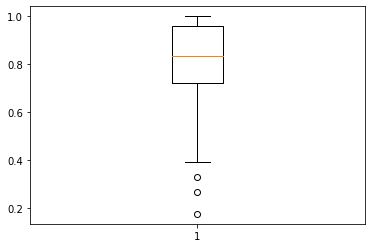

In [6]:
self_confidence_label_quality_scores = cleanlab.rank.get_self_confidence_for_each_label(
    reverse_ohe_truth,
    predictions.cpu().numpy(),
)
plt.hist(self_confidence_label_quality_scores)
plt.figure()
plt.boxplot(self_confidence_label_quality_scores)

Its interesting to note the distribution of self-confidance based ranking. Looking at less at 0.3 confidance samples, we note two samples index 74 and 181. 

74 is definitely a label error as there is an airplane in the image around 200, 200 grid mark on the runway! Yay!! 
181 is really yuck image, suffice to say its OOD image. Looking at other images in the sample, this is really poor quality.

So, there we have it, 2 very good results!!

[ 74 181]


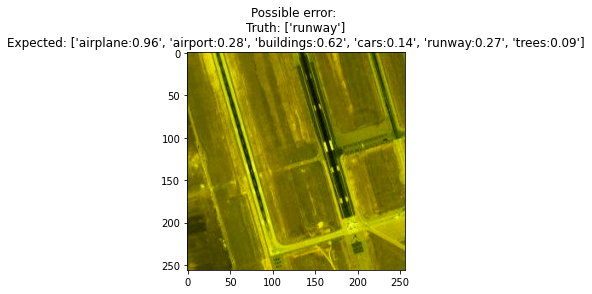

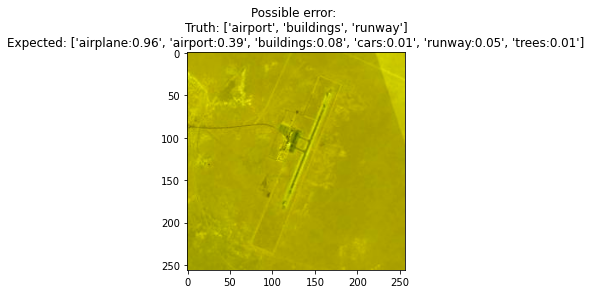

In [11]:
bad_qlt_indices=np.where(self_confidence_label_quality_scores < 0.3)[0]
print(bad_qlt_indices)
for idx in bad_qlt_indices:
    img = UnNormalise()(images[idx])
    plt.imshow(np.transpose(img.cpu().numpy(), [1, 2, 0]))
    expected_str = [f"{b}:{np.round(float(a), 2)}" for a, b in zip(predictions[idx], data_module.categories())]
    title = f"Possible error: \nTruth: {[data_module.categories()[a] for a in reverse_ohe_truth[idx]]}\nExpected: {expected_str}"
    plt.title(title)
    plt.draw()
    plt.pause(0.1)

## 2.1 Rank with entropy

Entropy is a good way to measure uncertainity. So, lets look at `get_confidence_weighted_entropy_for_each_label` ranking! This method, uses confidance weight entropy as name suggests.

{'whiskers': [<matplotlib.lines.Line2D at 0x7fb8ea3cf9a0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb899047520>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb8ea3cfc70>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb899047460>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fb899047cd0>],
 'means': []}

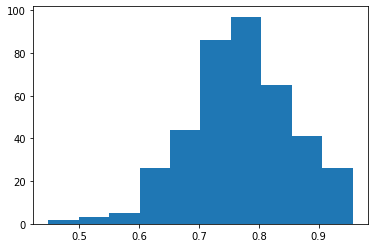

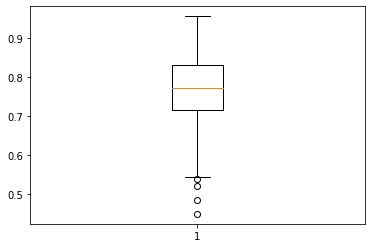

In [21]:
entropy_label_quality_scores = cleanlab.rank.get_confidence_weighted_entropy_for_each_label(
    reverse_ohe_truth,
    predictions.cpu().numpy(),
)
plt.hist(entropy_label_quality_scores)
plt.figure()
plt.boxplot(entropy_label_quality_scores)

Ok, so boxplot tells me 2 datapoints, below 0.5 threshold, lets see what they are!!
Boom! Same as before - 100% hit at 0.5 threshold

In [38]:
quality_n_confidance_poor=set(np.where(entropy_label_quality_scores < 0.5)[0].tolist()
   ).intersection(
    np.where(self_confidence_label_quality_scores < 0.5)[0].tolist()
)

print("Overlaps between entropy and self confidance count:", quality_n_confidance_poor)

# Are these available in noisy sample calcuated in step 1?
print("Overlaps with noisy samples:", set(ordered_label_errors).intersection(quality_n_confidance_poor))

Overlaps between entropy and self confidance count: {74, 181}
Overlaps with noisy samples: {74, 181}


Cool! So we have an agreement in all previous approaches!!

![](https://c.tenor.com/Hci5RHk27a0AAAAM/yes-please-dance.gif)

Lets look at some more 0.3-0.4 range self confidence samples!

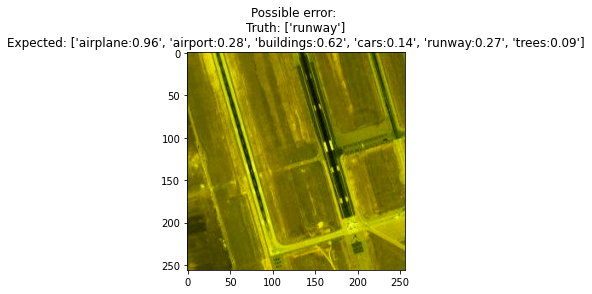

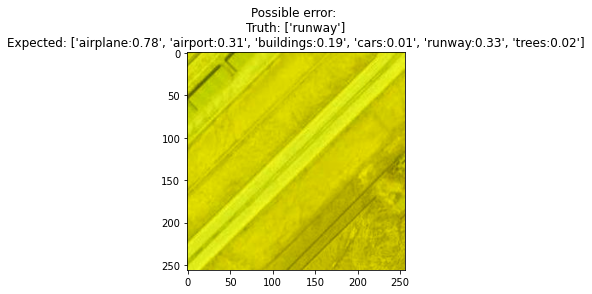

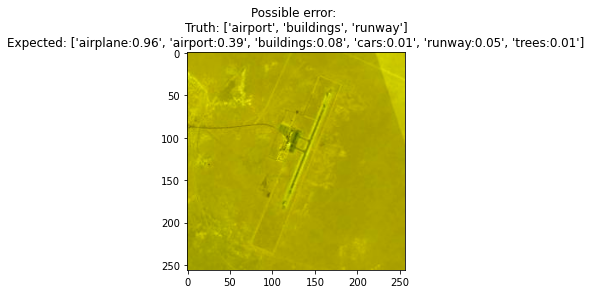

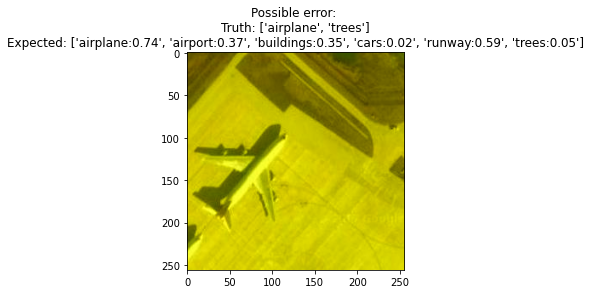

In [33]:
for idx in np.where(self_confidence_label_quality_scores < 0.4)[0].tolist():
    img = UnNormalise()(images[idx])
    plt.imshow(np.transpose(img.cpu().numpy(), [1, 2, 0]))
    expected_str = [f"{b}:{np.round(float(a), 2)}" for a, b in zip(predictions[idx], data_module.categories())]
    title = f"Possible error: \nTruth: {[data_module.categories()[a] for a in reverse_ohe_truth[idx]]}\nExpected: {expected_str}"
    plt.title(title)
    plt.draw()
    plt.pause(0.1)

## 3. Count

This is where we get pair-wise joint distribution of `P(given label | true label)`. There are bunch of APIs, but I am going to use `compute_confident_joint`. But, thresholds are very handy to have classwise tunes, so there is a nice handy API `cleanlab.count.get_confident_thresholds` to estimate the threshold. So, we estimate thresholds first and then use! 

In [30]:
confident_thresholds = cleanlab.count.get_confident_thresholds(
         truth,
         predictions,
)

IndexError: too many indices for tensor of dimension 1

Woops! That did not work well! Github issue for this is [here](https://github.com/cleanlab/cleanlab/issues/263). In the meantime, lets see the count, sadly, without `thresholds`.

In [32]:
a_confident_joint=cleanlab.count.compute_confident_joint(
    reverse_ohe_truth,
    predictions.cpu().numpy(),
    multi_label=True
#     thresholds=confident_thresholds
)
a_confident_joint

array([[121,  28,  35,  17,  29,   6],
       [ 30,  51,  59,   6,  60,  27],
       [ 25,  54,  62,   8,  65,  29],
       [ 12,   3,   5,   6,   0,   0],
       [  7,  52,  59,   0,  73,  32],
       [  1,  28,  31,   0,  35,  22]])

I have no idea how to interpret this for multi-label. So rest laters!